# Feature Engineering

---

Steps Taken

1. Import Packages
2. Load Data
3. Feature Engineering

---

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(color_codes=True)

In [3]:
#converting to datetime format

df = pd.read_csv('../Datasets/clean_data_after_eda.csv')

date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')

# df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
# df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
# df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
# df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [4]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


## Feature engineering on the price dataset.


In [5]:
price_df = pd.read_csv('../Datasets/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


Intuitively, from a business POV a price change between the end of the preceeding year and start of next year can be used as a feature with better predictive power.

In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [7]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


Analyzing the 44 columns in the dataframe extracted from the cleaned data after EDA to analyze thorougly and remove any non usable fields/columns.

In [8]:
df.nunique()

id                                 14606
channel_sales                          8
cons_12m                           11065
cons_gas_12m                        2112
cons_last_month                     4751
date_activ                          1796
date_end                             368
date_modif_prod                     2129
date_renewal                         386
forecast_cons_12m                  13993
forecast_cons_year                  4218
forecast_discount_energy              12
forecast_meter_rent_12m             3528
forecast_price_energy_off_peak       516
forecast_price_energy_peak           329
forecast_price_pow_off_peak           41
has_gas                                2
imp_cons                            7752
margin_gross_pow_ele                2391
margin_net_pow_ele                  2391
nb_prod_act                           10
net_margin                         11965
num_years_antig                       13
origin_up                              6
pow_max         

### Average price change across consecutive periods
For different energy/power prices across different timelines of the year, the average difference between the consecutive periods can be realized as another predicitve feature.

In [9]:
#Aggreate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [10]:
#Calculating the mean difference across consecutive time periods in the year.

def consecutive_diff(df, cols, suffix='_mean_diff'):
    """
    Calculating specific differences: off_peak - peak, peak - mid_peak, off_peak - mid_peak
    """
    ordered_periods = ['off_peak', 'peak', 'mid_peak']

    for i in range(len(ordered_periods)):
        for j in range(i + 1, len(ordered_periods)):
            p1, p2 = ordered_periods[i], ordered_periods[j]
            col1 = f'price_{p1}_{cols}'
            col2 = f'price_{p2}_{cols}'
            new_col = f'{p1}_{p2}_{cols}{suffix}'
            df[new_col] = df[col1] - df[col2]
    return df
        
mean_prices = consecutive_diff(mean_prices, 'var')
mean_prices = consecutive_diff(mean_prices, 'fix')

columns_to_keep = ['id'] + [col for col in mean_prices.columns if 'mean_diff' in col]

df = pd.merge(df, mean_prices[columns_to_keep], on='id')
df.head()


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.058257,0.034219,18.590255,26.040925,7.450670
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.149609,0.007124,44.311375,44.311375,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.170512,0.088421,44.385450,44.385450,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.151210,0.000000,44.400265,44.400265,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.051309,0.030773,16.275263,24.412893,8.137629


These features may be useful because they add more granularity to the existing feature set. Instead of looking at differences across an entire year, features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`) are added. The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

---

### Max price change across periods and months

Another way to engineer features is to add features exhibiting maximum change of mean price between months/periods.

In [11]:
#Aggregate average prices per period by company and month

mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()


In [12]:
# Calculating the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [13]:
# Calculating the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [14]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.034219,18.590255,26.040925,7.450670,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.007124,44.311375,44.311375,0.000000,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.088421,44.385450,44.385450,0.000000,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.400265,44.400265,0.000000,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.030773,16.275263,24.412893,8.137629,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


As some utility consumer, sudden increase/hikes in the power/energy prices can lead to churning of the customer. Hence, the maximum increase of average monthly price differences can be another helpful metric.

### Tenure or how long the company has been a client of PowerCo could be another feature to include in the model building.

In [15]:
df['tenure'] = ((df['date_end'] - df['date_activ']).dt.days/365).astype(int)
tenure_churn = df.groupby(['tenure']).agg({'churn' : 'mean'}).sort_values(by='churn', ascending=False)
tenure_churn

,churn
tenure,
2,0.176471
3,0.143874
4,0.127473
13,0.095238
5,0.091999
12,0.083333
7,0.075472
6,0.075407
11,0.059783


It is evident that mostly companies who are a client for less than 5 years are more likely to churn than companies who are not.

---
### Transforming dates to months

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [16]:
def convert_months(reference_date, df, column):
    """Input a column with timedeltas and return months"""

    time_delta = reference_date - df[column]
    months = (time_delta.dt.days/30).astype(int)
    return months

In [17]:
#Creating reference date
reference_date = datetime(2016, 1, 1)

#Columns to convert
df['months_active'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_active,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,31,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,77,-8,77,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,69,-3,69,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,70,-2,70,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,72,-2,72,9


Deriving meaningful features through datetime columns in the dataframe can prove helpful when utilizing them as features. For example, an active client who has stayed more with the company is more likely to be a stable client with lesser probability of churn compared the new client with a higher volatility. Hence, added the **'months_activ'** feature. Similarly, **months_to_end** describe how soon the current contract with PowerCo is ending and can be a decider whether the client wishes to switch towards a new supplier or quit. Likewise, **months_modif_prod** indicate the client's engagement since lesser the time since modification, more engaged is the client while **months_renewal** shows the client's commitment with the company as more the time since renewal, higher the risk of churn.

In [18]:
#Dropping date columns from which the new columns were created

date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
df.drop(columns=date_columns, axis=1, inplace=True)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_active,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,31,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,77,-8,77,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,69,-3,69,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,70,-2,70,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,72,-2,72,9


Boolean columns transformation for feature enablement.

In [19]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


As evident from a business perspective, a person buying gas from PowerCo shows they buy multiple products and hence are more likely to be a loyal customer. This statement gets backed up by the above numbers which clearly indicate that customers who do not buy gas have 2% more churn rate than the gas buying customers.

### Transformation of the categorical data

Transforming categorical features to numerical helps in building features ready for model ingestion. There are multiple ways to encode categorical features, **dummy variables** or **one hot encoding** being one of the most common one.

In [20]:
df['channel_sales'] = df['channel_sales'].astype('category')
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

As evident, out of the 8 categories of the channel sales column, 3 have way less numbers than the other five. So, it will be wise to drop them.

In [21]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel', dtype='int')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,tenure,months_active,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,3,31,-5,2,6,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,7,77,-8,77,4,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,6,69,-3,69,8,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,6,70,-2,70,9,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,6,72,-2,72,9,1,0,0,0,0


In [22]:
#Similar to channel_sales, origin_up can be encoded.
df['origin_up'] = df['origin_up'].astype('category')

df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [23]:
#Dropping the last three categories as they have very few observations with encoding.
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,2,6,0,0,1,0,0,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,77,4,1,0,0,0,0,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,69,8,0,0,1,0,0,True,False,False
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,70,9,0,0,0,1,0,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,72,9,1,0,0,0,0,True,False,False


### Transforming numerical data

As observed in the EDA part, several numeric columns has outliers or were highly skewed. An appropriate transformation needs to be applied to the numeric columns for removing outliers and making them better features. Since, most of the original distributions were positively skewed, logarithmic transformation can be an appropriate method. Other techniques include square root or cubic root of the features.
**Note** While applying the logarithmic transformation, applying log to 0 is not defined, so imputation of a constant value (1) will be applied wherever needed.

In [24]:
# Descriptive statistical observation of skewed columns.

skewed_cols = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed_cols].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


It's evident that certain columns have a really high standard deviation which is not desirable for a reliable model to build upon.

In [25]:
#Applying the logarithmic transformation

def log_transform(df, columns):
    """
    Apply log transformation to specified columns in the DataFrame.
    """
    for col in columns:
        df[col] = np.log10(df[col] + 1)  # Using log1p to handle zero values
    return df
df = log_transform(df, skewed_cols)
# Checking the skewness after transformation
df[skewed_cols].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.050918,1.517203,0.055766,0.020918,1.636058
std,0.884515,1.717071,1.769305,0.683592,1.584986,0.267388,0.571481,0.009438,0.020296,0.134237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.047796,0.000000,1.619163
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.058109,0.035085,1.656207
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.059316,0.040933,1.656207
max,6.792889,6.618528,5.887169,4.918575,5.243970,1.491362,2.778376,0.105157,0.077722,1.780075


Comparing the descriptive statistics before and after the logarithmic transformation applied, it is clear a fair reduction in the skewness has been achieved. One can verify through plotting the distributions.

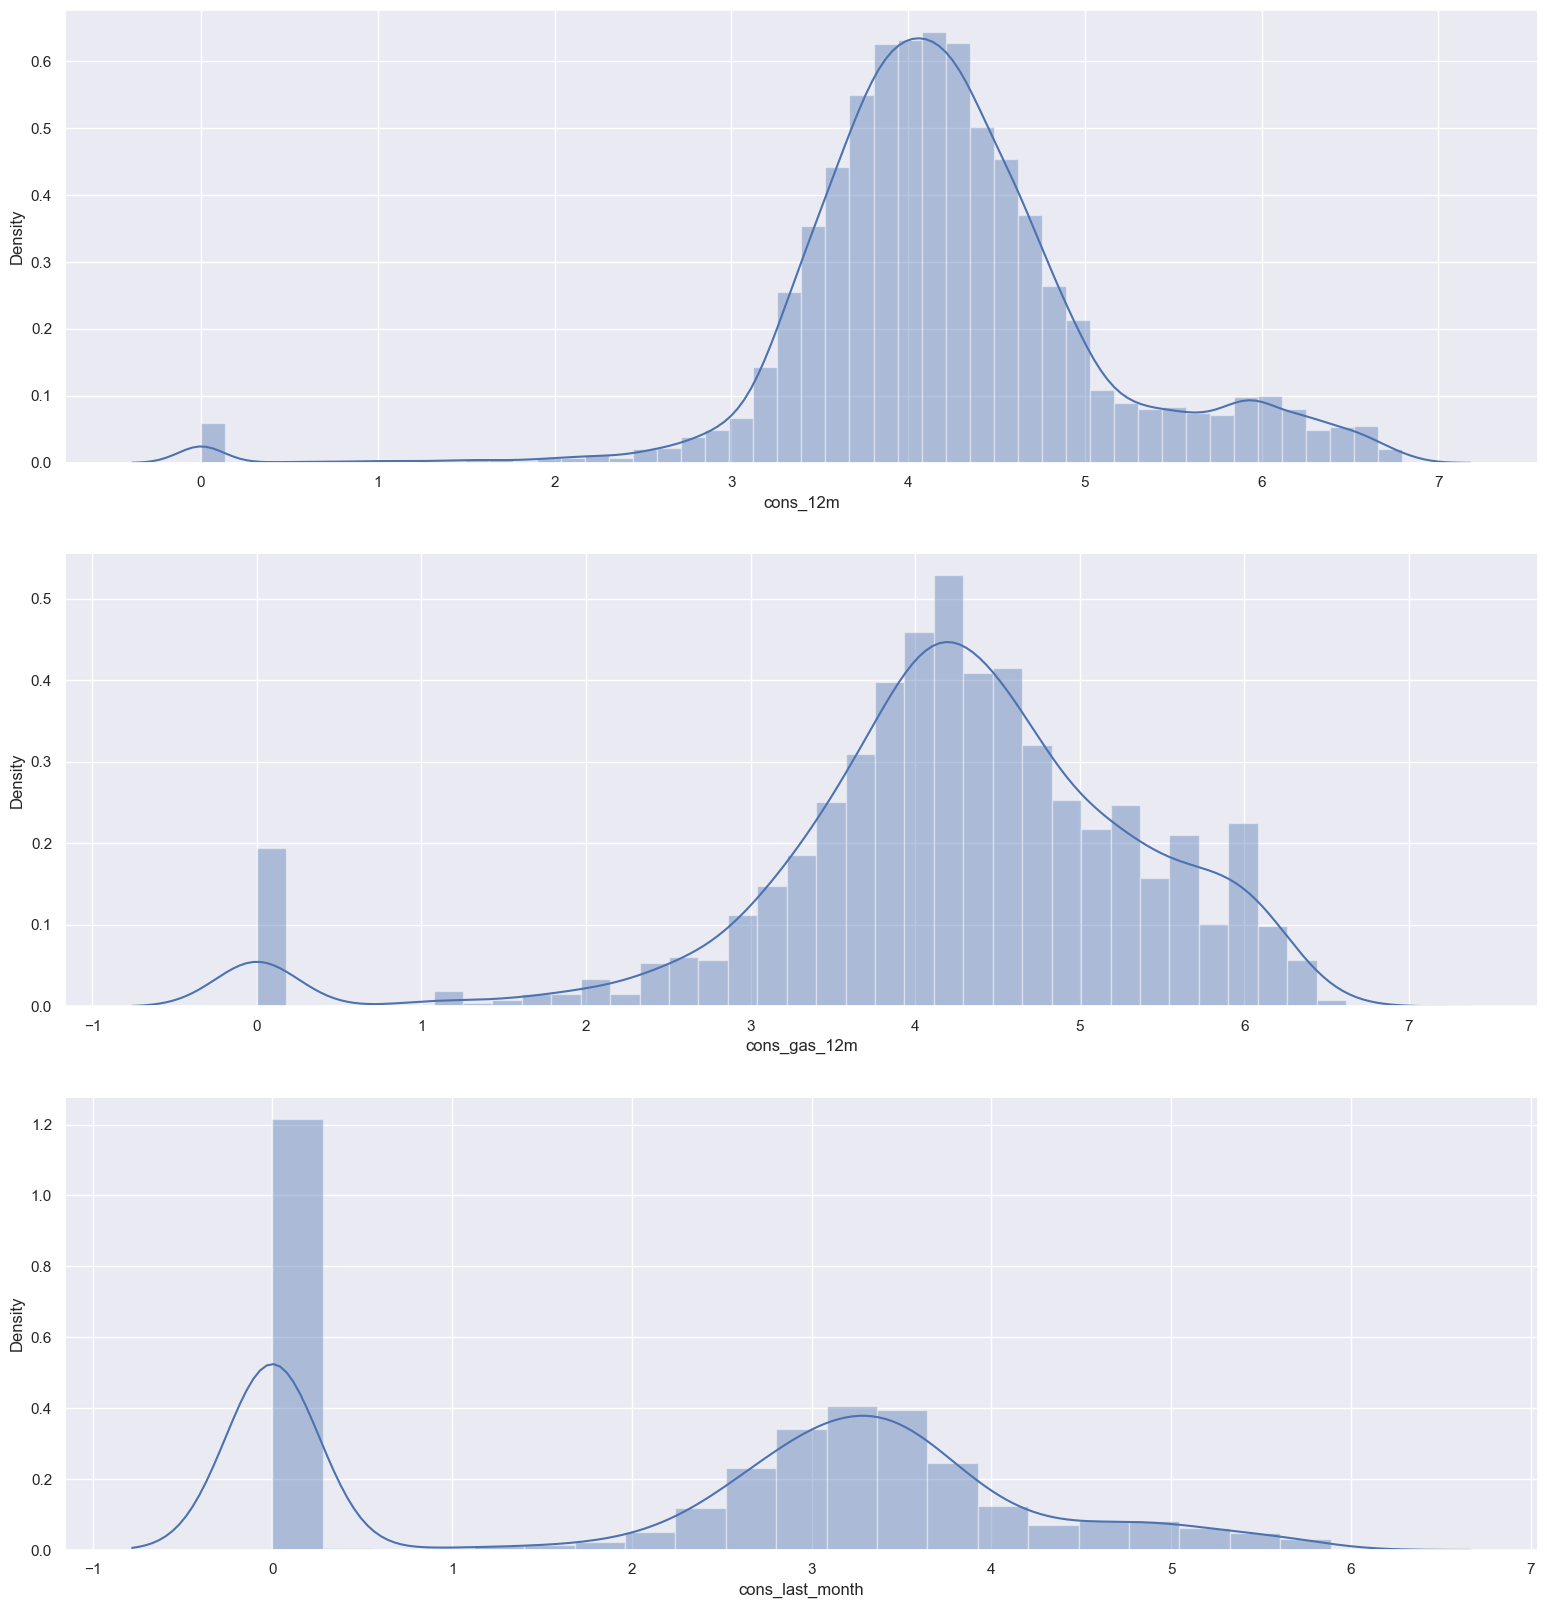

In [26]:
fig, axs = plt.subplots(nrows=3, figsize=(19,20))

#Plotting the histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()


### Correlation

One of the most important metric of determing the correct feature/column for model building can be linear or Pearson's correlation.

In [27]:
df_numeric = df.select_dtypes(include='number')
df_numeric.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,tenure,months_active,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.047073,0.040659,1.619163,...,3,31,-5,2,6,0,0,1,0,0
1,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.059075,0.000000,1.656207,...,7,77,-8,77,4,1,0,0,0,0
2,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.066622,0.036589,1.656207,...,6,69,-3,69,8,0,0,1,0,0
3,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.059448,0.000000,1.656207,...,6,70,-2,70,9,0,0,0,1,0
4,3.646011,0.000000,2.721811,2.650065,2.721811,0.0,2.122969,0.048014,0.041399,1.619163,...,6,72,-2,72,9,1,0,0,0,0


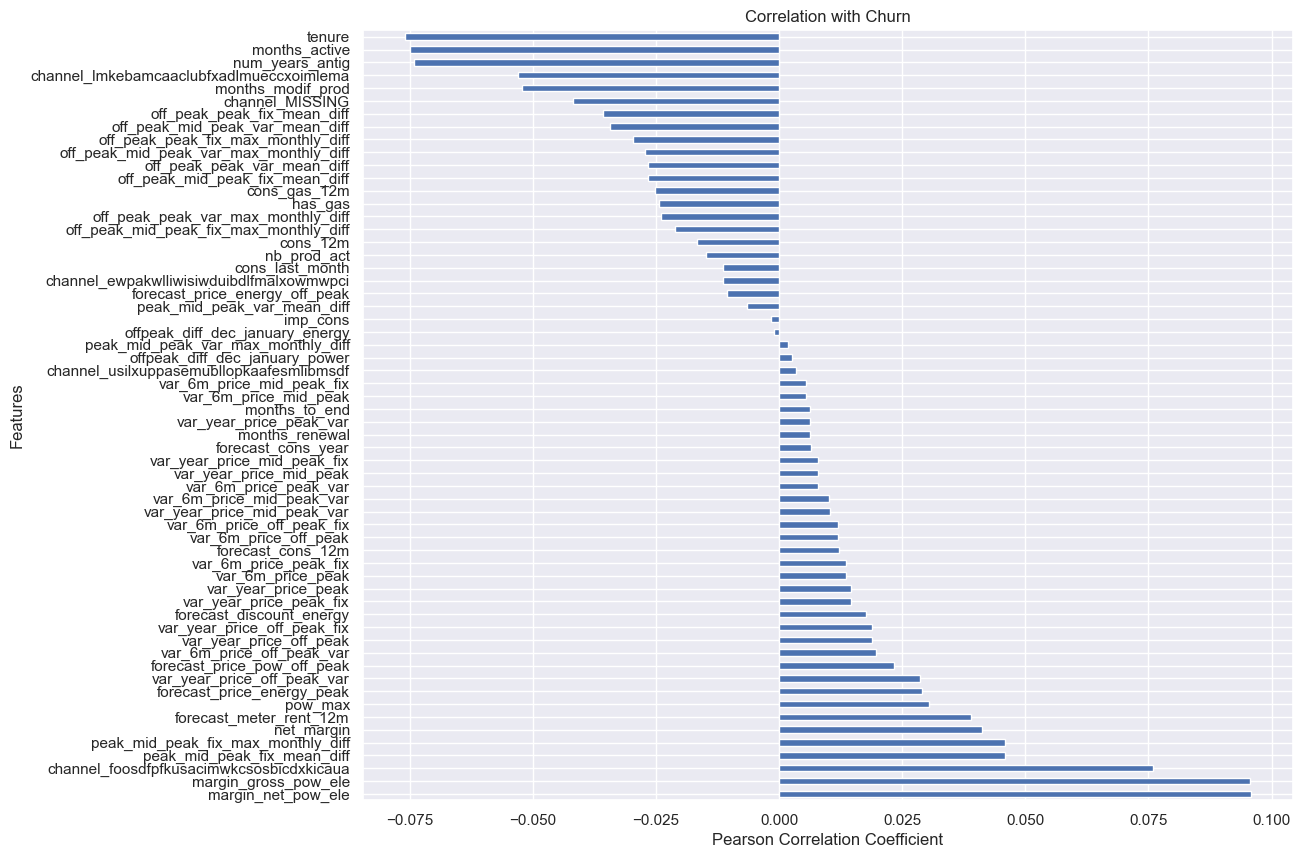

In [28]:
correlations = df_numeric.corr()['churn'].sort_values(ascending=False)
plt.figure(figsize=(12, 10))
correlations.drop('churn').plot(kind='barh')
plt.title('Correlation with Churn')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')
plt.show()

As evident from the pearson correlation, there is a poor linear relationship between predictor variables and target variable churn since the highest correlation does not surpass 0.1 which suggests high non-linear relationship. One of the suitable methods of checking what features hold a higher predictive power is to use the feature importance metric of random forest classifier model. This also helps in capturing the non-linear relationships of predictors with the target variable.

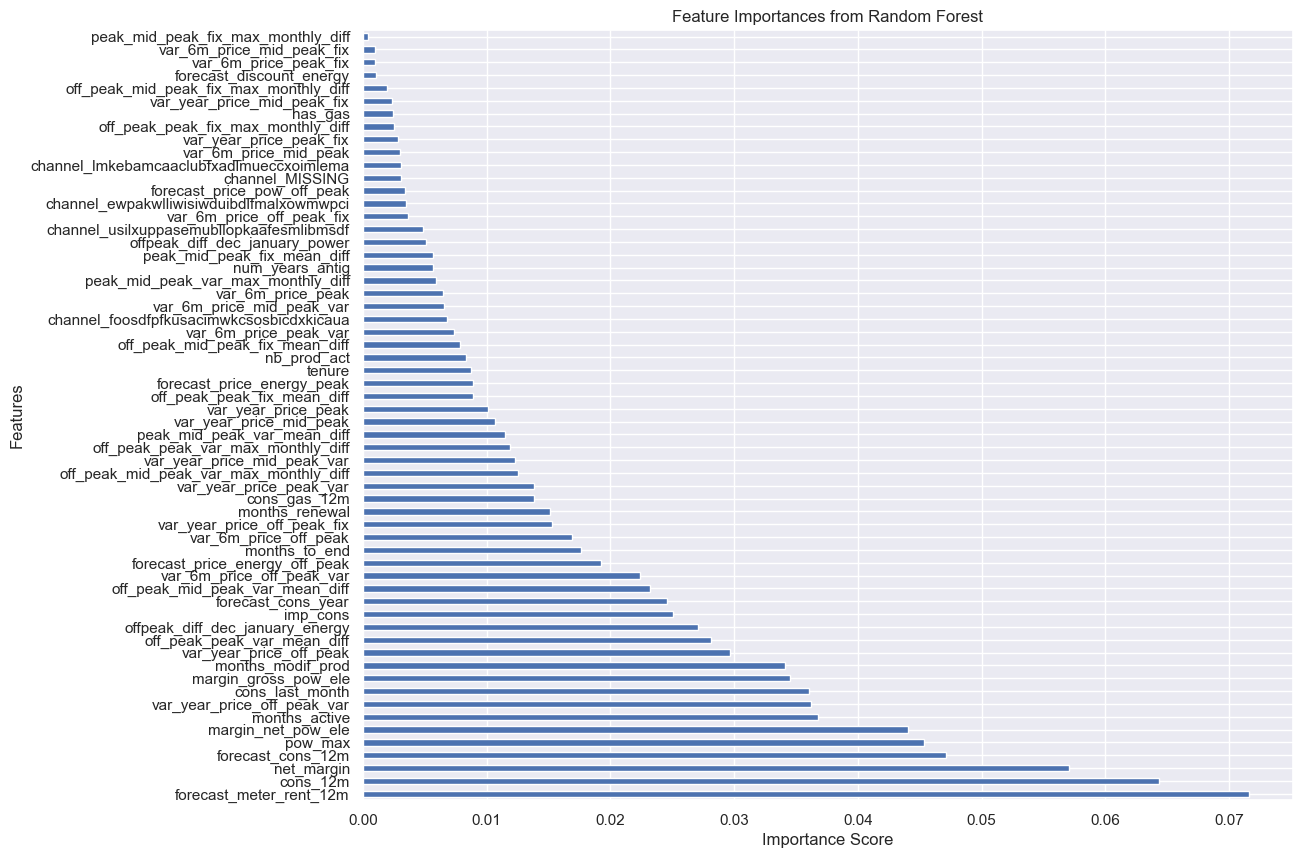

In [29]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split

X = df_numeric.drop('churn', axis=1)
y = df_numeric['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 10))
feature_importances.plot(kind='barh')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Applying feature engineering to certain fields to extract derived fields for obtaining new features with better predictive power. Checking for multicolinearity with variance inflation factor (VIF).

In [30]:
!pip install statsmodels

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature

def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

def remove_high_vif_features(df, vif_threshold=5):
    df_processed = df.copy()
    while True:
        vif_result = calculate_vif(df_processed)
        highest_vif_feature = vif_result.sort_values(by="VIF", ascending=False).iloc[0]

        if highest_vif_feature["VIF"] > vif_threshold:
            print(f"Removing feature: {highest_vif_feature['Features']} with VIF = {highest_vif_feature['VIF']:.2f}")
            df_processed = df_processed.drop(columns=[highest_vif_feature["Features"]])
        else:
            break
    print("\nFeatures after VIF reduction:")
    print(calculate_vif(df_processed))
    return df_processed

In [32]:
X_numeric = df_numeric.drop('churn', axis=1)

X_numeric_reduced_vif = remove_high_vif_features(X_numeric, vif_threshold=5)


Removing feature: var_year_price_off_peak with VIF = inf
Removing feature: var_year_price_peak with VIF = inf
Removing feature: var_year_price_mid_peak with VIF = inf
Removing feature: var_6m_price_off_peak_var with VIF = inf
Removing feature: off_peak_mid_peak_var_mean_diff with VIF = inf
Removing feature: peak_mid_peak_fix_mean_diff with VIF = inf
Removing feature: var_6m_price_peak with VIF = inf
Removing feature: var_6m_price_mid_peak_fix with VIF = inf
Removing feature: var_6m_price_off_peak with VIF = 40297782953.98
Removing feature: off_peak_mid_peak_fix_mean_diff with VIF = 159089.86
Removing feature: off_peak_mid_peak_fix_max_monthly_diff with VIF = 36106.51
Removing feature: margin_gross_pow_ele with VIF = 14503.14
Removing feature: off_peak_mid_peak_var_max_monthly_diff with VIF = 2909.67
Removing feature: off_peak_peak_fix_mean_diff with VIF = 1511.09
Removing feature: forecast_price_energy_off_peak with VIF = 1373.02
Removing feature: months_active with VIF = 1015.37
Remov

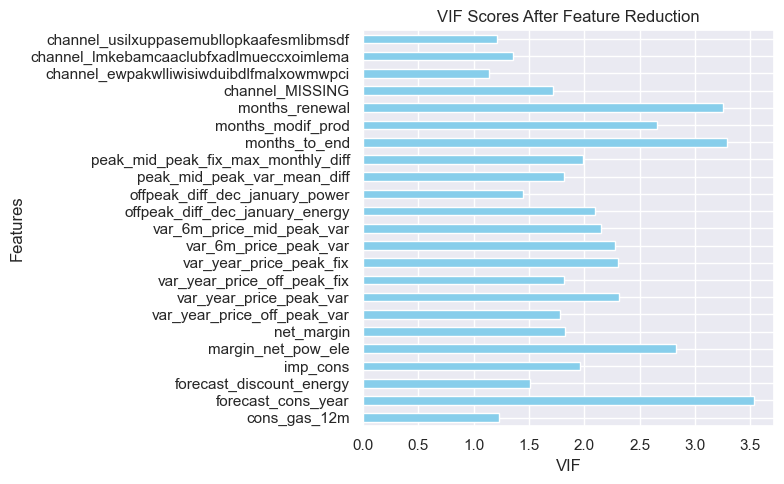

In [34]:
vif_final = calculate_vif(X_numeric_reduced_vif)
vif_final.set_index("Features")["VIF"].plot(kind="barh", color="skyblue", figsize=(8, 5))
plt.title("VIF Scores After Feature Reduction")
plt.xlabel("VIF")
plt.tight_layout()
plt.show()

The VIF analysis suggests that a large number of features have high multi colinearity and some have less which can be used to derive new meaningful features or directly for model building. Based on the insights derived from the linear correlation, random forest feature importance, and VIF, features mainly from historic and forecasted consumption, margins, and prices can be used as features with a better predictive power. In addition, the engineered features like months_renewal, months_modif_prod, months_to_end and mean differences among periods and months also serve as a strong predictor as thought intuitively.